### projection model => project points per player  
- [ ]    Basic Stats  
- [ ]    Usage  
- [ ]    Percentage of team scoring  
- [ ]    Injuries  
- [ ]    Bye week
- [ ]    Injuries to Key Teammates
- [ ]    Individual Matchups
- [ ]    Opposing Team (record, defense, injuries, etc.)
- [ ]    Home/Away
- [ ]    Weather
- [ ]    Expert Picks
- [x]    Other Fantasy Projections

### selection mechanism => choose optimal team within parameters
- [ ]    maximize value (pts/salary)
- [x]    Linear Optimization
    - Inspiration: https://github.com/breeko/Fantasy_LP/blob/master/fantasy_lp_final.ipynb

In [1]:
import pandas as pd
# from matplotlib import pyplot as plt
import numpy as np

In [2]:
year = 2024
week = 13

In [3]:
primary_dir = f"/Users/adamschiller/OneDrive - BOOZ ALLEN HAMILTON/"
sal_dir = primary_dir+"Weekly Salary Data"

data_dir = "2024_fantasy_data"

# Get Data

## Antonio's Official Data

### weeks 8,9,13

In [4]:
# df = pd.read_csv(f"{sal_dir}/Week{week}_Salaries_rotowire-NFL-projected-roster-percent.csv")
df = pd.read_csv(f"{sal_dir}/Week{week}_salaries_rotowire.csv")

def format_antonio_salary_data(df):
    df.rename(columns={'PLAYER': 'name', 'FPTS': 'prediction', 'POS': 'pos', 'SAL': 'salary'}, inplace=True)
    # df.loc[df['pos']=='DST', 'pos'] = 'Def'
    df.loc[df['pos']=='D', 'pos'] = 'DST'
    df = df[['name','pos','salary','prediction']]
    return df

adf = format_antonio_salary_data(df)
adf

,name,pos,salary,prediction
0,Caleb Williams,QB,5300,15.54
1,Cooper Rush,QB,4800,13.82
2,Drew Lock,QB,4500,13.21
3,Jordan Love,QB,6300,18.46
4,Tua Tagovailoa,QB,6000,16.52
...,...,...,...,...
597,David Martin-Robinson,TE,2500,0.00
598,Deonte Harty,WR,3000,0.00
599,Colton Dowell,WR,3000,0.00
600,Teagan Quitoriano,TE,2500,0.00


### weeks 10+

In [ ]:
df = pd.read_csv(f"{sal_dir}/Week{week}_salaries_rotowire.csv")

def format_antonio_salary_data(df):
    df.rename(columns={'player': 'name', 'proj_rotowire': 'prediction', 'position': 'pos'}, inplace=True)
    # df.loc[df['pos']=='DST', 'pos'] = 'Def'
    df.loc[df['pos']=='D', 'pos'] = 'DST'
    df = df[['name','pos','salary','prediction']]
    return df

adf = format_antonio_salary_data(df)
adf

In [5]:
adf['pos'].value_counts()

pos
WR     217
RB     134
TE     133
QB      86
DST     32
Name: count, dtype: int64

## Rotowire

In [38]:
# https://www.rotowire.com/daily/nfl/dfs-opportunities.php?site=DraftKings  # choose full slate
def rotowire_csv(filepath):
    df = pd.read_csv(filepath)
    df.rename(columns={'PLAYER': 'name', 'POS': 'pos', 'SAL': 'salary', 'FPTS': 'prediction'}, inplace=True)
    df.loc[df['pos']=='D', 'pos'] = 'DST'
    df = df[['name','pos','salary','prediction']]
    return df
    
rdf = rotowire_csv(f"{data_dir}/week{week}_rotowire-NFL-projected-roster-percent.csv")
rdf

,name,pos,salary,prediction
0,Daniel Jones,QB,5300,17.33
1,Justin Herbert,QB,5200,16.32
2,Josh Allen,QB,7700,22.92
3,Aaron Rodgers,QB,5700,16.40
4,Kyler Murray,QB,6300,18.21
...,...,...,...,...
523,Patrick Murtagh,TE,2500,0.00
524,David White,WR,3000,0.00
525,Jordan Travis,QB,4000,0.00
526,Keilan Robinson,RB,4000,0.00


In [40]:
len(rdf[rdf['pos']=='DST'])

28

In [41]:
adf = rdf

## Daily Fantasy Fuel

In [6]:
# map defense names for dff based on rotowire names
def defense_mapping(df):
    return {n.split(' ')[-1]: n for n in df[df['pos']=='DST']['name']}

defense_map = defense_mapping(adf)

def apply_defense_map(x):
    try:
        return defense_map[x]
    except KeyError:
        return x

In [7]:
url = "https://www.dailyfantasyfuel.com/nfl/projections/"
url

'https://www.dailyfantasyfuel.com/nfl/projections/'

In [14]:
# https://www.dailyfantasyfuel.com/nfl/projections/
def dff_csv(filepath):
    df = pd.read_csv(filepath)
    df['name'] = df['first_name']+' '+df['last_name']
    df.rename(columns={'position': 'pos', 'ppg_projection': 'prediction'}, inplace=True)
    # fix names for defenses based on mapping created by rotowire data above
    df.loc[df['pos']=='DST', 'name'] = df['first_name'].apply(lambda x: apply_defense_map(x))
    # df.loc[df['pos']=='DST', 'pos'] = 'Def'
    df = df[['name','pos','injury_status','salary','prediction']]
    return df

dff = dff_csv(f"{data_dir}/week{week}_DFF_NFL_cheatsheet.csv")
dff

,name,pos,injury_status,salary,prediction
0,Jahmyr Gibbs,RB,NaN,7500,18.6
1,Jordan Love,QB,NaN,6300,17.8
2,Jared Goff,QB,NaN,6500,17.7
3,Amon-Ra St. Brown,WR,Q,8000,17.5
4,Caleb Williams,QB,NaN,5300,17.4
...,...,...,...,...,...
440,Nyheim Miller-Hines,RB,O,4000,0.0
441,Gardner Minshew II,QB,O,4000,0.0
442,Tyler Higbee,TE,O,3200,0.0
443,Jordan Travis,QB,O,4000,0.0


In [15]:
dff['pos'].value_counts()

pos
WR     164
RB     117
TE      95
QB      37
DST     32
Name: count, dtype: int64

## BettingPros - fantasy prop bets

In [16]:
import re

from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from io import StringIO

In [17]:
def last_page(driver):
    page_info = driver.find_element(By.CLASS_NAME, "typography.pbcs-page-pagination__text")
    cur_page, pages = re.findall(r'\d+', page_info.text)
    print("Current Page: ", cur_page)
    return int(cur_page) == int(pages)

def get_page_data(driver):
    "return current page player data as list"
    res = []
    lines = driver.find_elements(By.CLASS_NAME, "grouped-items-with-sticky-footer__content")
    
    for line in lines:
        r = line.text.split('\n')
        team, pos = r[2].split(' - ')
        res.append({
            'name': r[1],
            'team': team,
            'pos': pos,
            'prop': r[3],
            'projected': r[5].split(' ')[-1]
        })
    return res

def next_page(driver):
    # next page
    child = driver.find_element(By.CLASS_NAME, "fas.fa-angle-right")
    parent = child.find_element(By.XPATH, "./../..")
    
    # clicking didn't work (overlapping element) but executing script to click does...
    # parent.click()
    driver.execute_script("arguments[0].click();", parent)

def get_bettingpros_data():
    # current week
    # url = "https://www.bettingpros.com/nfl/picks/prop-bets/bet/weekly-fantasy-points/"
    url = "https://www.bettingpros.com/nfl/picks/prize-picks/bet/weekly-fantasy-points/"
    
    driver = webdriver.Chrome()
    driver.implicitly_wait(15)
    driver.get(url)
    
    data = []
    
    while True:
        data.extend(get_page_data(driver))
        if last_page(driver):
            break
        else:
            next_page(driver)
    driver.close()
    return pd.DataFrame(data)

In [18]:
bpdf = get_bettingpros_data()

Current Page:  1
Current Page:  2
Current Page:  3


In [19]:
bpdf['pos'].value_counts()

pos
WR    22
QB    14
RB    13
TE    11
Name: count, dtype: int64

## Fantasy Sharks

In [38]:
segment = 818 + week
url = f"https://www.fantasysharks.com/apps/bert/forecasts/projections.php?csv=1&Sort=&Segment={segment}&Position=99&scoring=16&League=-1&uid=4&uid2=&printable="
# url = f"https://www.fantasysharks.com/apps/bert/forecasts/projections.php?League=-1&Position=99&scoring=16&Segment={segment}&uid=4"
url

'https://www.fantasysharks.com/apps/bert/forecasts/projections.php?csv=1&Sort=&Segment=831&Position=99&scoring=16&League=-1&uid=4&uid2=&printable='

In [20]:
def split_name(x):
    res = x.split(', ')
    return res[1] + " " + res[0]

In [21]:
def fantasysharks_csv(filepath):
    df = pd.read_csv(filepath)
    df.rename(columns={'Player Name': 'name', 'Position': 'pos', 'Pts': 'prediction'}, inplace=True)
    df = df[df['pos'].isin(["QB", "WR", "RB", "TE", "D"])]
    df['name'] = df['name'].apply(split_name)
    df.loc[df['pos']=='D', 'pos'] = 'DST'
    df = df[['name','pos','prediction']]
    return df

shark_df = fantasysharks_csv(f"{data_dir}/week{week}_projections.csv")

In [22]:
shark_df

,name,pos,prediction
0,Jalen Hurts,QB,23.9
1,Saquon Barkley,RB,23.2
2,Joe Mixon,RB,21.6
3,Lamar Jackson,QB,21.0
4,Baker Mayfield,QB,21.0
...,...,...,...
1152,Jeff Driskel,QB,0.0
1153,Brandon Allen,QB,0.0
1154,Carson Wentz,QB,0.0
1155,Trevor Siemian,QB,0.0


In [23]:
shark_df['pos'].value_counts()

pos
WR     173
RB     117
TE      95
QB      78
DST     32
Name: count, dtype: int64

## CBS

In [24]:
def fix_dumb_team_names(x):
    if 'N.Y.' in x:
        return x.replace('N.Y.', 'New York')
    elif 'L.A.' in x:
        return x.replace('L.A.', 'Los Angeles')
    else:
        return x

In [25]:
def defense_mapping(df):
    return {' '.join(n.split(' ')[:-1]): n for n in df[df['pos']=='DST']['name']}

opp_defense_map = defense_mapping(adf)

def apply_opp_defense_map(x):
    x = fix_dumb_team_names(x)
    try:
        return opp_defense_map[x]
    except KeyError:
        return x

In [26]:
def pos_df(pos):
    df = pd.read_html(f"https://www.cbssports.com/fantasy/football/stats/{pos}/{year}/{week}/projections/nonppr/")[0]
    df.columns = df.columns.droplevel(0)

    # convert to .5 PPR
    rec = df['rec  Receptions']/2 if 'rec  Receptions' in df else 0
    df['prediction'] = df['fppg  Fantasy Points Per Game'] + rec

    # fix names
    if 'Player' in df:
        df['name'] =  df['Player'].apply(lambda x: x.split(pos)[1].strip().split("  ")[-1] if pos in x else np.nan)
        df.dropna(subset=['name'], inplace=True)
    if 'Team' in df:
        df['name'] = df['Team'].apply(lambda x: apply_opp_defense_map(x))

    df['pos'] = pos
    df = df[['name','pos','prediction']]
    return df

In [27]:
positions = ["QB", "WR", "RB", "TE", "DST"]
final = []
for pos in positions:
    final.append(pos_df(pos))
cbs_df = pd.concat(final)
cbs_df

,name,pos,prediction
0,Joe Burrow,QB,25.0
1,Patrick Mahomes,QB,24.4
2,Josh Allen,QB,23.6
3,Baker Mayfield,QB,23.4
4,Jayden Daniels,QB,23.0
...,...,...,...
27,Los Angeles Rams,DST,5.5
28,Chicago Bears,DST,5.4
29,Carolina Panthers,DST,5.3
30,Las Vegas Raiders,DST,4.7


In [28]:
cbs_df['pos'].value_counts()

pos
WR     100
TE     100
RB      96
QB      64
DST     32
Name: count, dtype: int64

## Others

### NFL

In [ ]:
# nfl_pos_idx = c("QB" = 1, "RB" = 2, "WR" = 3, "TE" = 4, "K" = 7, "DST" = 8)
# pos_scrape = nfl_pos_idx[pos]

# url = "https://fantasy.nfl.com/research/projections"

### ESPN

In [ ]:
# https://fantasy.espn.com/football/players/projections

# Standardize sources

In [23]:
# def remove_name_suffixes(df):
#     df['name'] = df['name'].str.replace(r'\s?(Jr|Sr|II|III).?', '', regex=True)
#     return df

In [29]:
name_map = {
    'Chig Okonkwo': 'Chigoziem Okonkwo',
    'D.J. Moore': 'DJ Moore',
    'Gabriel Davis': 'Gabe Davis',
    'Josh Palmer': 'Joshua Palmer',
}

def apply_name_map(x):
    if x in name_map:   
        print("fixed", x)
        return name_map[x]
    else:
        return x

def standardize_names(df):
    # remove suffixes
    df['name'] = df['name'].str.replace(r'\s?(Jr|Sr|II|III).?', '', regex=True)
    # apply map
    df['name'] = df['name'].apply(apply_name_map)
    return df

In [30]:
shark_df = standardize_names(shark_df)
cbs_df = standardize_names(cbs_df)
adf = standardize_names(adf)
dff = standardize_names(dff)

fixed D.J. Moore
fixed Josh Palmer
fixed Chig Okonkwo


/var/folders/pl/yvv0vk397x34b_lzgcmsd43w0000gp/T/ipykernel_96183/444051082.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name'] = df['name'].str.replace(r'\s?(Jr|Sr|II|III).?', '', regex=True)
/var/folders/pl/yvv0vk397x34b_lzgcmsd43w0000gp/T/ipykernel_96183/444051082.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name'] = df['name'].apply(apply_name_map)


In [31]:
bpdf = standardize_names(bpdf)
bpdf.rename(columns={'prop': 'prediction_prop', 'projected': 'prediction'}, inplace=True)
bpdf['prediction_prop'] = bpdf['prediction_prop'].astype(float)
bpdf['prediction'] = bpdf['prediction'].astype(float)
len(bpdf)

60

In [32]:
# TODO: determine which names don't match -> outer merge

def find_unmatched_names(df1, df2, on='name', thresh_col='prediction', thresh=5):
    "find unmatched names based on some column threshold value"
    merged_df = pd.merge(df1, df2, on=on, how='outer', indicator=True)
    
    # Filter for rows that are only present in one DataFrame
    mismatches = merged_df[merged_df['_merge'] != 'both']
    return mismatches[(mismatches[thresh_col+'_x']>thresh) | (mismatches[thresh_col+'_y']>thresh)]

In [34]:
dff[dff['name'].str.contains('Pacheco')]

,name,pos,injury_status,salary,prediction


In [33]:
find_unmatched_names(adf, dff)

,name,pos_x,salary_x,prediction_x,pos_y,injury_status,salary_y,prediction_y,_merge
242,Isiah Pacheco,RB,6200.0,14.45,NaN,NaN,NaN,NaN,left_only
248,Ja'Tavion Sanders,TE,3400.0,6.84,NaN,NaN,NaN,NaN,left_only
268,Jalen Coker,WR,3700.0,7.09,NaN,NaN,NaN,NaN,left_only


# Merge Sources

In [35]:
from typing import List, Union
from functools import reduce

def merge_dataframes(*dfs: pd.DataFrame, 
                    on: Union[str, List[str]], 
                    how: str = 'outer',
                    rename_duplicates: bool = True,
                    suffix_pattern: str = '_{i}') -> pd.DataFrame:
    """
    Merge multiple pandas DataFrames on specified column(s) while handling duplicate columns.
    
    Args:
        *dfs: Variable number of pandas DataFrames to merge
        on: Column name(s) to merge on. Can be a string or list of strings
        how: Type of merge to perform ('outer', 'inner', 'left', 'right'). Defaults to 'outer'
        rename_duplicates: If True, renames overlapping columns with suffixes before merging.
                         If False, uses pandas default behavior of _x, _y suffixes
        suffix_pattern: Pattern for suffix when rename_duplicates=True. 
                       Use {i} as placeholder for index
    
    Returns:
        pd.DataFrame: Merged DataFrame
        
    Raises:
        ValueError: If less than 2 DataFrames are provided or if merge column is missing
        TypeError: If inputs are not pandas DataFrames
    """
    # Input validation
    if len(dfs) < 2:
        raise ValueError("At least 2 DataFrames are required for merging")
    
    if not all(isinstance(df, pd.DataFrame) for df in dfs):
        raise TypeError("All arguments must be pandas DataFrames")
    
    # Convert single string to list for consistent handling
    merge_cols = [on] if isinstance(on, str) else on
    
    # Verify merge columns exist in all DataFrames
    for i, df in enumerate(dfs):
        missing_cols = set(merge_cols) - set(df.columns)
        if missing_cols:
            raise ValueError(f"DataFrame at index {i} is missing merge columns: {missing_cols}")
    
    if rename_duplicates:
        renamed_dfs = []
        # Keep track of all column names we've seen (except merge columns)
        all_cols = set()
        
        for i, df in enumerate(dfs):
            df = df.copy()
            # Get columns that aren't merge columns
            non_merge_cols = [col for col in df.columns if col not in merge_cols]
            
            # Find overlapping columns
            overlapping = set(non_merge_cols) & all_cols
            
            # Rename overlapping columns
            if overlapping:
                rename_dict = {col: f"{col}{suffix_pattern.format(i=i)}" for col in overlapping}
                df.rename(columns=rename_dict, inplace=True)
            
            # Add these columns to our tracking set
            all_cols.update(non_merge_cols)
            renamed_dfs.append(df)
        
        # Use renamed DataFrames for merging
        dfs_to_merge = renamed_dfs
    else:
        dfs_to_merge = dfs
    
    # Perform the merge using reduce
    try:
        merged = reduce(lambda left, right: pd.merge(left, right, on=merge_cols, how=how), dfs_to_merge)
        return merged
    
    except Exception as e:
        raise Exception(f"Error during merge operation: {str(e)}")

In [36]:
merged = merge_dataframes(
    adf, 
    dff[['name','injury_status','prediction']], 
    shark_df[['name','prediction']], 
    cbs_df[['name','prediction']],
    bpdf[['name','prediction_prop','prediction']],
    on='name', how='left'
)
# remove injured
merged = merged[merged['injury_status'].isna()]
merged = merged.drop(columns=['injury_status'])
# merged = merged.fillna(0.0)
# get mean prediction (disregard when value isn't present)
merged['mean_pred'] = merged.filter(like='prediction').replace(0, np.nan).mean(axis=1)
# filter out preds w/ fewer than 3 values
merged['pred_count'] = merged.filter(like='prediction').gt(0).sum(axis=1)
merged = merged[merged['pred_count']>=3]
merged

,name,pos,salary,prediction,prediction_1,prediction_2,prediction_3,prediction_prop,prediction_4,mean_pred,pred_count
0,Caleb Williams,QB,5300,15.54,17.4,14.8,15.60,17.0,15.6,15.990000,6
1,Cooper Rush,QB,4800,13.82,13.7,15.1,16.40,13.5,14.3,14.470000,6
2,Drew Lock,QB,4500,13.21,13.1,0.6,14.00,12.5,13.0,11.068333,6
3,Jordan Love,QB,6300,18.46,17.8,17.5,20.80,17.0,16.8,18.060000,6
4,Tua Tagovailoa,QB,6000,16.52,16.7,15.3,15.60,15.0,15.7,15.803333,6
...,...,...,...,...,...,...,...,...,...,...,...
500,Nate Adkins,TE,2500,0.00,1.6,2.5,1.50,NaN,NaN,1.866667,3
510,Ross Dwelley,TE,2500,0.00,0.3,1.0,0.85,NaN,NaN,0.716667,3
544,Cody Schrader,RB,4000,0.17,0.1,NaN,0.65,NaN,NaN,0.306667,3
545,Raheem Blackshear,RB,4000,0.17,0.7,0.7,0.75,NaN,NaN,0.580000,4


In [37]:
merged['pos'].value_counts()

pos
WR     130
RB      99
TE      83
QB      33
DST     32
Name: count, dtype: int64

In [38]:
# save prediction_dataframe
merged.to_csv(f"{data_dir}/week{week}_predictions.csv", index=False)

# Top Projected per Pos

In [50]:
def avg_per_dollar(df, col):
    df['Avg Value'] = df[col] / (df['salary'] / 1000)
    return df.sort_values('Avg Value', ascending=False)

pdf = avg_per_dollar(merged, 'mean_pred')

In [51]:
top_QBs = pdf[pdf.pos=='QB']
top_QBs.head(5)

,name,pos,salary,prediction,prediction_1,prediction_2,prediction_3,prediction_prop,prediction_4,mean_pred,pred_count,Avg Value
1,Justin Herbert,QB,5400,17.27,19.7,18.6,18.4,NaN,NaN,18.4925,4,3.424537
2,Tommy Devito,QB,4000,12.82,13.6,13.6,14.0,NaN,NaN,13.5050,4,3.376250
6,Geno Smith,QB,5700,17.07,19.2,15.8,21.4,NaN,NaN,18.3675,4,3.222368
5,Jayden Daniels,QB,7000,21.17,23.5,18.3,24.8,NaN,NaN,21.9425,4,3.134643
4,Kyler Murray,QB,6200,18.58,18.7,18.2,20.6,NaN,NaN,19.0200,4,3.067742


In [52]:
top_RBs = pdf[pdf.pos=='RB']
top_RBs.head(5)

,name,pos,salary,prediction,prediction_1,prediction_2,prediction_3,prediction_prop,prediction_4,mean_pred,pred_count,Avg Value
34,De'Von Achane,RB,7500,17.93,21.7,18.5,17.15,19.0,18.7,18.830000,6,2.510667
35,Christian Mccaffrey,RB,8500,20.40,21.6,20.2,18.95,NaN,NaN,20.287500,4,2.386765
49,Jahmyr Gibbs,RB,7300,15.88,17.2,18.8,17.25,NaN,NaN,17.282500,4,2.367466
63,Joe Mixon,RB,8000,17.65,21.5,19.8,16.90,18.5,19.1,18.908333,6,2.363542
47,Brian Robinson,RB,5600,12.96,15.0,14.7,9.70,NaN,NaN,13.090000,4,2.337500


In [53]:
top_WRs = pdf[pdf.pos=='WR']
top_WRs.head(5)

,name,pos,salary,prediction,prediction_1,prediction_2,prediction_3,prediction_prop,prediction_4,mean_pred,pred_count,Avg Value
30,Jakobi Meyers,WR,5100,12.81,12.9,14.1,9.15,NaN,NaN,12.2400,4,2.400000
36,Deandre Hopkins,WR,5400,12.76,12.6,12.8,9.25,NaN,NaN,11.8525,4,2.194907
105,Jauan Jennings,WR,5600,10.86,13.2,13.0,11.95,NaN,NaN,12.2525,4,2.187946
68,Dk Metcalf,WR,6600,14.64,15.0,14.9,12.75,NaN,NaN,14.3225,4,2.170076
81,Ladd Mcconkey,WR,6000,12.30,15.2,13.2,10.95,NaN,NaN,12.9125,4,2.152083


In [54]:
top_TEs = pdf[pdf.pos=='TE']
top_TEs.head(5)

,name,pos,salary,prediction,prediction_1,prediction_2,prediction_3,prediction_prop,prediction_4,mean_pred,pred_count,Avg Value
9,Travis Kelce,TE,5800,16.85,16.8,15.0,12.20,NaN,NaN,15.212500,4,2.622845
50,Zach Ertz,TE,3800,8.39,9.6,9.2,8.55,NaN,NaN,8.935000,4,2.351316
21,Will Dissly,TE,3500,8.91,11.2,6.5,5.95,NaN,NaN,8.140000,4,2.325714
44,Jonnu Smith,TE,4100,9.64,10.3,9.2,8.10,9.5,10.1,9.473333,6,2.310569
145,Hunter Henry,TE,4000,6.99,10.8,9.1,7.15,10.5,10.2,9.123333,6,2.280833


In [55]:
# players[players.Pos == 'Def'].head(3)
top_Defs = pdf[pdf.pos=='DST']
top_Defs.head(5)

,name,pos,salary,prediction,prediction_1,prediction_2,prediction_3,prediction_prop,prediction_4,mean_pred,pred_count,Avg Value
33,Chicago Bears,DST,2500,6.03,7.5,8.2,12.8,NaN,NaN,8.6325,4,3.453000
43,Denver Broncos,DST,3200,7.45,8.2,12.3,14.3,NaN,NaN,10.5625,4,3.300781
51,Pittsburgh Steelers,DST,3500,7.83,9.4,12.9,15.3,NaN,NaN,11.3575,4,3.245000
61,Houston Texans,DST,3600,7.85,9.8,9.4,17.4,NaN,NaN,11.1125,4,3.086806
57,Minnesota Vikings,DST,3400,7.53,8.4,10.7,14.3,NaN,NaN,10.2325,4,3.009559


# Team Selection

$$\begin{aligned} 
objective &= maximize\ team\ points \\ 
team\ salary &\leq salary\ cap \\
team &= 1\ QB + (2|3)\ RB + (3|4)\ WR + (1|2)\ TE + 1\ DEF \\
team &\leq 9\ total\ players \\
\end{aligned}$$

In [39]:
# %pip install pulp

In [39]:
from pulp import *

class PulpSelection():
    def __init__(self, df, pts_col="prediction", sal_col="salary", name_col="name", salary_cap=50000):
        self.df = df
        self.vars = self.populate_vars(pts_col, sal_col, name_col)
        self.model = self.optimize(salary_cap)
        self.players = self.player_names()
        self.selection = self.selection_df()
        
    def populate_vars(self, pts_col, sal_col, name_col):
        df = self.df
        salaries = {}
        points = {}
        for pos in df.pos.unique():
            available_pos = df[df.pos == pos]
            salary = list(available_pos[[name_col,sal_col]].set_index(name_col).to_dict().values())[0]
            point = list(available_pos[[name_col,pts_col]].set_index(name_col).to_dict().values())[0]
            salaries[pos] = salary
            points[pos] = point
            
        self.salaries = salaries
        self.points = points
        return {k: LpVariable.dict(k, v, cat="Binary") for k, v in points.items()}

    def player_names(self):
        players = {}
        for d in self.vars.values():
            for k,v in d.items():
                players[v] = k
        return players
            
    pos_num_available = {
        "QB": 1,
        "RB": 2,
        "WR": 3,
        "TE": 1,
        "DST": 1
    }

    def optimize(self, salary_cap):
        prob = LpProblem("FFModel", LpMaximize)
        rewards = []
        costs = []

        for pos, players in self.vars.items():
            costs += lpSum([self.salaries[pos][i] * self.vars[pos][i] for i in players])
            rewards += lpSum([self.points[pos][i] * self.vars[pos][i] for i in players])
            if pos in ['RB','WR','TE']:
                prob += lpSum([self.vars[pos][i] for i in players]) <= self.pos_num_available[pos]+1
                prob += lpSum([self.vars[pos][i] for i in players]) >= self.pos_num_available[pos]
            else:
                prob += lpSum([self.vars[pos][i] for i in players]) == self.pos_num_available[pos]
        prob += lpSum(prob.variables()) == 9    # flex -> max of 9 total players

        prob += lpSum(rewards)
        prob += lpSum(costs) <= salary_cap
        print(prob.solve(pulp.PULP_CBC_CMD(msg=False)))  #suppress solver output
        return prob
    
    def selection_df(self):
        selections = [self.players[p] for p in self.model.variables() if p.varValue > 0]
        team = self.df[self.df.name.isin(selections)]
        return team

In [50]:
def pick_team(pred_df, pts_col, act_pts='fpts'):
    pred_df[pts_col] = pred_df[pts_col].fillna(0.0)
    model = PulpSelection(pred_df, pts_col=pts_col)
    team = model.selection

    columns_to_keep = ['name','pos','salary',pts_col,act_pts]
    team = team[[col for col in columns_to_keep if col in team]]
    print(f"Total predicted points: {sum(team[pts_col])}", end="  ")
    if 'fpts' in team:
        print(f"Total actual points: {sum(team[act_pts])}", end="  ")
    print(f"Total Salary: {sum(team['salary'])}")
    print(team)
    return team

In [69]:
team = pick_team(merged, 'mean_pred')

1
Total predicted points: 133.57833333333332  Total Salary: 49900
               name  pos  salary  mean_pred
5       Jonnu Smith   TE    4300  10.893333
10         DJ Moore   WR    5600  12.806667
115  Justin Herbert   QB    5600  19.148333
116     Chase Brown   RB    6200  17.802500
120    Travis Kelce   TE    5600  14.490000
146    Alvin Kamara   RB    7700  18.925000
175  Denver Broncos  DST    3300  11.175000
198   Ladd McConkey   WR    6100  14.790000
244    Brian Thomas   WR    5500  13.547500


In [52]:
team = pick_team(merged, 'prediction_1')

1
Total predicted points: 143.6  Total Salary: 50000
               name  pos  salary  prediction_1
7       Rico Dowdle   RB    5500          15.5
115  Justin Herbert   QB    5600          20.9
116     Chase Brown   RB    6200          19.6
146    Alvin Kamara   RB    7700          22.1
156   Jakobi Meyers   WR    5300          13.0
175  Denver Broncos  DST    3300           9.3
198   Ladd McConkey   WR    6100          15.8
213     Evan Engram   TE    4800          13.9
244    Brian Thomas   WR    5500          13.5


## Save Picks to CSV

In [70]:
remote_dir = f"{primary_dir}/Weekly Team Picks/Week {week:02}/"
local_dir = "2024_weekly_picks/"
fname = f"Adam_week{week}_picks.csv"

# save version in each location
for d in [local_dir, remote_dir]:
    team[['pos','name','salary']].to_csv(d+fname, index=False)

# Optimal Picks per Week

In [19]:
# salary + scoring
df = df.join(week_df[['name', 'fpts']].set_index('name'), on='name')
df

,name,pos,salary,prediction,fpts
0,Patrick Mahomes,QB,8100,25.420,21.34
1,Joe Burrow,QB,6300,20.025,14.80
2,Trevor Lawrence,QB,6500,20.465,15.74
4,Sam Howell,QB,5500,16.570,18.34
5,Dak Prescott,QB,6200,18.470,NaN
...,...,...,...,...,...
351,Jason Brownlee,WR,3000,0.225,NaN
354,Brandon Bolden,RB,4000,0.365,NaN
355,Davis Allen,TE,2500,0.195,NaN
356,Mike Boone,RB,4000,0.580,1.10


In [20]:
def show_optimal_picks(df, pts_col='fpts', sal_col='salary'):
    week = df.dropna()
    model = PulpSelection(week, pts_col=pts_col)
    team = model.selection
    print("\nTotal points: {}     Total salary: {}\n".format(sum(team[pts_col]), sum(team[sal_col])))
    return team

In [21]:
show_optimal_picks(df)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /usr/local/Caskroom/miniconda/base/envs/default/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/cv/pyjmd76x58dbyxrhzycj6c880000gp/T/277c43891ee94cf3b082240ccce60552-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/cv/pyjmd76x58dbyxrhzycj6c880000gp/T/277c43891ee94cf3b082240ccce60552-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 15 COLUMNS
At line 1690 RHS
At line 1701 BOUNDS
At line 1952 ENDATA
Problem MODEL has 10 rows, 250 columns and 947 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 242.62 - 0.00 seconds
Cgl0004I processed model has 7 rows, 230 columns (230 integer (226 of which binary)) and 690 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -242.62
Cbc0038I Cleaned solution of -242.62
C

,name,pos,salary,prediction,fpts
11,Drake London,WR,4800,12.345,24.50
28,Jared Goff,QB,6400,16.830,25.42
63,Raheem Mostert,RB,6400,15.740,37.20
67,Cooper Kupp,WR,9000,20.780,30.80
69,Kyren Williams,RB,6500,15.255,24.80
88,Tyreek Hill,WR,9300,22.715,31.30
90,Adam Thielen,WR,5900,13.610,31.50
92,Minnesota Vikings,Def,3000,6.075,21.00
97,Dalton Schultz,TE,3600,8.195,16.10


# Scoring submission

In [4]:
def get_scores(year, week):
    res = []
    for pos in ['QB','RB','WR','TE','dst']:
        url = (f"https://fantasydata.com/nfl/fantasy-football-leaders?scope=game"
               f"&sp={year}_REG&week_from={week}&week_to={week}&position={pos}"
                "&scoring=fpts_draftkings&order_by=fpts_draftkings&sort_dir=desc")
        df = pd.read_html(url)[0]
        if pos == 'dst':
            df = df.rename(columns={'TEAM': 'name'})
            df['pos'] = 'DST'
        else:
            df.columns = df.columns.droplevel(0)
        df = df.rename(columns=str.lower)
        res.append(df[['name','pos','fpts']])
    return pd.concat(res)

In [5]:
score_df = get_scores(year, week)
score_df

,name,pos,fpts
0,Jayden Daniels,QB,32.4
1,Tua Tagovailoa,QB,31.5
2,Caleb Williams,QB,29.9
3,Patrick Mahomes,QB,28.8
4,Sam Darnold,QB,24.1
...,...,...,...
21,New York Giants,DST,1.0
22,Las Vegas Raiders,DST,0.0
23,Los Angeles Chargers,DST,0.0
24,San Francisco 49ers,DST,-2.0


In [6]:
# save scoring dataframe
score_df.to_csv(f"{data_dir}/week{week}_scores.csv", index=False)

In [7]:
def score_submission(df, score_df):
    df = df.join(score_df[['name', 'fpts']].set_index('name'), on='name')  # join in scores dataframe
    df = df.fillna(0)  # fill empties with 0
    print(f"Total Points in Week {week}:", sum(df['fpts']))
    return df

In [24]:
score_df[score_df['name'].str.contains("Amon")]

,name,pos,fpts
24,Amon-Ra St. Brown,WR,12.2


# Score mine

In [8]:
local_dir = "2024_weekly_picks/"
fname = f"Adam_week{week}_picks.csv"
team = pd.read_csv(local_dir+fname)

team = score_submission(team, score_df)

Total Points in Week 12: 103.2


In [9]:
team

,pos,name,salary,fpts
0,QB,Justin Herbert,5400,17.6
1,TE,Travis Kelce,5800,12.2
2,TE,Will Dissly,3500,8.7
3,WR,Jakobi Meyers,5100,25.1
4,RB,De'Von Achane,7500,20.6
5,RB,Christian Mccaffrey,8500,0.0
6,WR,Deandre Hopkins,5400,0.0
7,DST,Denver Broncos,3200,10.0
8,WR,Jauan Jennings,5600,9.0


# Score all in dir

In [17]:
def standardize_submissions(df):
    "takes in submissions of all different types and standardizes them to be scored automatically"
    df.columns = map(str.lower, df.columns)  # lowercase column names
    df = df.head(9)   # only keep player rows - first 9
    # rename position to pos if it exists in columns
    if 'position' in df.columns: 
        df = df.rename({'position':'pos'}, axis=1)
    df = df.loc[:,~df.columns.duplicated()]   #remove duplicated columns if any
    df.loc[df.pos.isin(['D','Def']),'pos'] = 'DST'  # default to using DST as defense
    df = df.rename({'player':'name'}, axis=1)  # rename player to name
    df['name'] = df['name'].str.strip()   # strip whitespace from name column
    # df.loc[df['pos']=='DST', 'name'] = df['name'].apply(lambda x: apply_defense_map(x))  # map defense names
    # check if name contains a comma -> convert from last, first to first last in prep for the join
    # if ',' in df.loc[df['pos']=='QB', 'name'].item():
    #     df = change_last_name_first(df)
    return df

In [18]:
import os

def score_all_in_dir(directory, score_df):
    for f in os.listdir(directory):
        # if not (f.startswith("Sebastian") or f.startswith("Rashod")):
        # if not (f.startswith('SCORED_') or f.startswith('all_players_') or f.startswith('Week6_Totals')) :
            
        if f.endswith('.csv'):
            j = pd.read_csv(directory+f)
        elif f.endswith('.xlsx'):
            j = pd.read_excel(directory+f)
        print(f)
        try:
            df = standardize_submissions(j)
            df = score_submission(df, score_df)
            print(df, end='\n\n')
        except Exception as e:
            print(e)
            return j

In [19]:
pick_dir = f"Weekly Team Picks/Week {format(week, '02d')}/"

In [20]:
score_all_in_dir(primary_dir+pick_dir, score_df)

SpencerR_week12_2024.csv
Total Points in Week 12: 105.7
      id first_name    last_name              name  \
0  20016      Miami     Dolphins    Miami Dolphins   
1  17692     Jayden      Daniels    Jayden Daniels   
2  13517     Jakobi       Meyers     Jakobi Meyers   
3  17674     Marvin     Harrison   Marvin Harrison   
4  16919        Zay      Flowers       Zay Flowers   
5  11707        Joe        Mixon         Joe Mixon   
6  15907      Brian     Robinson    Brian Robinson   
7   8783     Travis        Kelce      Travis Kelce   
8  16855       Luke  Schoonmaker  Luke Schoonmaker   

                                       url  injury  actions actions_trigger  \
0    /football/player/miami-dolphins-20016     0.0  &#9881;            open   
1    /football/player/jayden-daniels-17692     0.0  &#9881;            open   
2     /football/player/jakobi-meyers-13517     0.0  &#9881;            open   
3   /football/player/marvin-harrison-17674     0.0  &#9881;            open   
4       

# Scoring Analytics

In [66]:
def final_scored_df(pred_df, score_df):
    # standardize names
    score_df = standardize_names(score_df)
    pred_df = standardize_names(pred_df)
    # add join key
    score_df['id'] = score_df['name'].str.lower()
    pred_df['id'] = pred_df['name'].str.lower()
    # inner join
    df = pd.merge(pred_df, score_df[['id','fpts']], on='id', how='inner', indicator=True)
    # filter out players with 0 fantasy points
    df = df[df['fpts']>0]
    return df

In [ ]:
# # check mismatches
# outer_df = pd.merge(pred_df, score_df[['id','fpts']], on='id', how='outer', indicator=True)
# mismatches = outer_df[outer_df['_merge'] != 'both']
# mismatches

In [70]:
def rmse(df, pred, true='fpts'):
    squared_error = (df[true] - df[pred]) ** 2
    return float(np.sqrt(squared_error.mean()))

In [56]:
def pick_team(pred_df, pts_col):
    pred_df[pts_col] = pred_df[pts_col].fillna(0.0)
    model = PulpSelection(pred_df, pts_col=pts_col)
    team = model.selection
    team = team[['name','pos','salary',pts_col,'fpts']]
    print("Total predicted points: {}   Total actual points: {}   Total Salary: {}\n".format(sum(team[pts_col]), sum(team['fpts']), sum(team['salary'])))
    print(team)
    return team

### Week 8

In [143]:
week = 8

In [144]:
pred_df = pd.read_csv(f"{data_dir}/week{week}_predictions.csv")
score_df = pd.read_csv(f"{data_dir}/week{week}_scores.csv")

In [145]:
df = final_scored_df(pred_df, score_df)
df

fixed Chig Okonkwo


,name,pos,salary,prediction,prediction_1,prediction_2,mean_pred,pred_count,id,fpts,_merge
0,Justin Herbert,QB,5400,16.11,16.2,15.3,15.870000,3,justin herbert,24.1,both
1,Bo Nix,QB,5600,16.79,19.3,16.8,17.630000,3,bo nix,29.8,both
2,Matthew Stafford,QB,5500,15.74,15.7,13.2,14.880000,3,matthew stafford,25.8,both
3,Jalen Mcmillan,WR,3700,10.72,10.4,14.1,11.740000,3,jalen mcmillan,9.2,both
4,Brock Purdy,QB,6300,18.21,18.7,19.0,18.636667,3,brock purdy,26.0,both
...,...,...,...,...,...,...,...,...,...,...,...
273,Isaac Guerendo,RB,6100,1.17,2.0,5.0,2.723333,3,isaac guerendo,19.2,both
274,Patrick Taylor,RB,4600,0.33,0.3,2.6,1.076667,3,patrick taylor,0.9,both
276,Hunter Long,TE,2500,0.36,0.6,1.8,0.920000,3,hunter long,2.8,both
279,Tim Jones,WR,3000,0.40,0.3,1.4,0.700000,3,tim jones,3.0,both


#### Pick scores

In [53]:
week8 = {'mean_pred': 148.2, 'prediction': 170.0, 'prediction_1': 123.3, 'prediction_2': 85.8}

In [146]:
team = pick_team(df, 'mean_pred')

1
Total predicted points: 132.57   Total actual points: 148.2   Total Salary: 50000

                name  pos  salary  mean_pred  fpts
1             Bo Nix   QB    5600  17.630000  29.8
3     Jalen Mcmillan   WR    3700  11.740000   9.2
7         Cade Otton   TE    3500   9.930000  29.1
18       Tyreek Hill   WR    7000  18.176667  13.2
27       Breece Hall   RB    7300  19.596667   9.9
33     De'Von Achane   RB    6200  15.223333  26.7
57    Denver Broncos  DST    3700  10.330000   7.0
70      Malik Nabers   WR    7000  15.736667  14.1
87  Javonte Williams   RB    6000  14.206667   9.2


In [147]:
team = pick_team(df, 'prediction')

1
Total predicted points: 128.98   Total actual points: 170.0   Total Salary: 49900

                    name  pos  salary  prediction  fpts
3         Jalen Mcmillan   WR    3700       10.72   9.2
5           Kyler Murray   QB    6400       18.66  25.2
7             Cade Otton   TE    3500        9.99  29.1
18           Tyreek Hill   WR    7000       19.13  13.2
24  Los Angeles Chargers  DST    3300        8.23  12.0
27           Breece Hall   RB    7300       18.49   9.9
33         De'Von Achane   RB    6200       14.87  26.7
40      Courtland Sutton   WR    5300       12.12  21.1
43        Bijan Robinson   RB    7200       16.77  23.6


In [148]:
team = pick_team(df, 'prediction_1')

1
Total predicted points: 141.1   Total actual points: 123.3   Total Salary: 50000

                 name  pos  salary  prediction_1  fpts
1              Bo Nix   QB    5600          19.3  29.8
3      Jalen Mcmillan   WR    3700          10.4   9.2
18        Tyreek Hill   WR    7000          18.7  13.2
27        Breece Hall   RB    7300          21.5   9.9
39       Travis Kelce   TE    6000          14.5  25.0
45   Baltimore Ravens  DST    3400           8.6   3.0
46        Aaron Jones   RB    6600          18.5  11.5
102       Trey Palmer   WR    3500          10.4   4.9
130      J.K. Dobbins   RB    6900          19.2  16.8


In [149]:
team = pick_team(df, 'prediction_2')

1
Total predicted points: 140.9   Total actual points: 85.8   Total Salary: 50000

               name  pos  salary  prediction_2  fpts
3    Jalen Mcmillan   WR    3700          14.1   9.2
17      Jordan Love   QB    7100          22.5   6.7
18      Tyreek Hill   WR    7000          16.7  13.2
27      Breece Hall   RB    7300          18.8   9.9
57   Denver Broncos  DST    3700          14.2   7.0
89        Cole Kmet   TE    4700          12.0   4.4
113    James Conner   RB    6500          17.4  14.9
132  Rashod Bateman   WR    4300          10.8   3.8
133   Rachaad White   RB    5700          14.4  16.7


#### RMSE

In [118]:
rmse(df, 'mean_pred', 'fpts')

6.408603881010567

In [119]:
rmse(df, 'prediction', 'fpts')

6.4828071972430665

In [120]:
rmse(df, 'prediction_1', 'fpts')

6.403842345588202

In [121]:
rmse(df, 'prediction_2', 'fpts')

6.593129562637069

### Week 9

In [122]:
week = 9

In [123]:
pred_df = pd.read_csv(f"{data_dir}/week{week}_predictions.csv")
score_df = pd.read_csv(f"{data_dir}/week{week}_scores.csv")

In [124]:
df = final_scored_df(pred_df, score_df)
df

fixed Chig Okonkwo


,name,pos,salary,prediction,prediction_1,prediction_2,mean_pred,pred_count,id,fpts,_merge
0,Josh Allen,QB,7700,23.59,22.6,18.8,21.663333,3,josh allen,23.1,both
1,Daniel Jones,QB,5200,16.05,17.6,12.6,15.416667,3,daniel jones,25.4,both
2,Gardner Minshew,QB,4500,13.67,14.2,12.0,13.290000,3,gardner minshew,4.0,both
3,Sam Darnold,QB,6000,18.23,19.6,14.4,17.410000,3,sam darnold,22.0,both
4,Matthew Stafford,QB,5700,17.23,17.1,14.8,16.376667,3,matthew stafford,18.9,both
...,...,...,...,...,...,...,...,...,...,...,...
258,Deejay Dallas,RB,4000,0.74,0.5,0.1,0.446667,3,deejay dallas,0.2,both
259,Jaheim Bell,TE,2500,0.61,0.4,0.7,0.570000,3,jaheim bell,1.1,both
261,Ryan Flournoy,WR,3000,0.34,0.4,1.8,0.846667,3,ryan flournoy,2.3,both
263,Jamycal Hasty,RB,4000,0.46,1.4,2.7,1.520000,3,jamycal hasty,0.7,both


#### Pick scores

In [56]:
week9 = {'mean_pred': 164.0, 'prediction': 119.2, 'prediction_1': 139.5, 'prediction_2': 190.1}

In [139]:
team = pick_team(df, 'mean_pred')

1
Total predicted points: 125.91333333333334   Total actual points: 164.0   Total Salary: 49900

                name  pos  salary  mean_pred  fpts
11     New York Jets  DST    2400   6.876667  14.0
13       Jalen Hurts   QB    7800  22.976667  29.9
17       Chris Olave   WR    6100  15.023333   2.3
29    Bijan Robinson   RB    7400  18.536667  21.5
39       David Moore   WR    3000   7.010000   4.0
40       Aaron Jones   RB    6600  16.206667  12.2
41     De'Von Achane   RB    6700  16.226667  32.1
47  Courtland Sutton   WR    5400  12.336667  26.3
70        Cade Otton   TE    4500  10.720000  21.7


In [140]:
team = pick_team(df, 'prediction')

1
Total predicted points: 127.89   Total actual points: 119.2   Total Salary: 50000

               name  pos  salary  prediction  fpts
0        Josh Allen   QB    7700       23.59  23.1
11    New York Jets  DST    2400        6.93  14.0
17      Chris Olave   WR    6100       16.27   2.3
23     Drake London   WR    6700       16.66  10.7
25   Cedric Tillman   WR    4300       10.90  19.5
29   Bijan Robinson   RB    7400       17.81  21.5
31      Breece Hall   RB    7500       17.71  10.5
38   Dalton Schultz   TE    4100        9.58   5.1
48  Ray-Ray Mccloud   WR    3800        8.44  12.5


In [141]:
team = pick_team(df, 'prediction_1')

1
Total predicted points: 136.2   Total actual points: 139.5   Total Salary: 50000

               name  pos  salary  prediction_1  fpts
3       Sam Darnold   QB    6000          19.6  22.0
11    New York Jets  DST    2400           7.0  14.0
17      Chris Olave   WR    6100          14.7   2.3
23     Drake London   WR    6700          16.8  10.7
25   Cedric Tillman   WR    4300          10.9  19.5
40      Aaron Jones   RB    6600          18.7  12.2
65      David Njoku   TE    5500          13.8   7.9
93      Chase Brown   RB    5900          16.8  29.7
144   Chuba Hubbard   RB    6500          17.9  21.2


In [142]:
team = pick_team(df, 'prediction_2')

1
Total predicted points: 137.3   Total actual points: 190.1   Total Salary: 49900

                  name  pos  salary  prediction_2  fpts
13         Jalen Hurts   QB    7800          24.7  29.9
39         David Moore   WR    3000           7.7   4.0
41       De'Von Achane   RB    6700          17.6  32.1
47    Courtland Sutton   WR    5400          13.3  26.3
50     Deandre Hopkins   WR    5000          12.8  28.6
53        Travis Kelce   TE    6300          16.1  26.0
58      Kyren Williams   RB    8000          22.1  10.5
70          Cade Otton   TE    4500          11.8  21.7
100  Minnesota Vikings  DST    3200          11.2  11.0


#### RMSE

In [78]:
rmse(df, 'mean_pred', 'fpts')

6.559237371342573

In [79]:
rmse(df, 'prediction', 'fpts')

6.785923226986376

In [80]:
rmse(df, 'prediction_1', 'fpts')

6.468272813625703

In [81]:
rmse(df, 'prediction_2', 'fpts')

6.661058634155653

### Week 10

In [150]:
week = 10

In [151]:
pred_df = pd.read_csv(f"{data_dir}/week{week}_predictions.csv")
score_df = pd.read_csv(f"{data_dir}/week{week}_scores.csv")

In [152]:
df = final_scored_df(pred_df, score_df)
df

fixed Chig Okonkwo


,name,pos,salary,prediction,prediction_1,prediction_2,mean_pred,pred_count,id,fpts,_merge
0,Daniel Jones,QB,5300,17.30,17.3,15.2,16.600000,3,daniel jones,14.2,both
1,Justin Herbert,QB,5200,16.30,16.4,16.1,16.266667,3,justin herbert,19.8,both
2,Josh Allen,QB,7700,22.82,22.8,22.1,22.573333,3,josh allen,20.2,both
3,Brock Purdy,QB,6500,19.05,19.6,21.0,19.883333,3,brock purdy,26.8,both
4,Matthew Stafford,QB,5600,16.07,16.6,14.3,15.656667,3,matthew stafford,10.7,both
...,...,...,...,...,...,...,...,...,...,...,...
257,Xavier Hutchinson,WR,3600,0.49,2.5,5.8,2.930000,3,xavier hutchinson,2.6,both
259,Jamycal Hasty,RB,4100,0.45,0.9,2.3,1.216667,3,jamycal hasty,3.4,both
264,Malik Washington,WR,3000,0.33,1.1,1.1,0.843333,3,malik washington,10.5,both
267,Will Shipley,RB,4000,0.55,0.6,0.6,0.583333,3,will shipley,3.4,both


#### Pick scores

In [57]:
week10 = {'mean_pred': 166.1, 'prediction': 102.1, 'prediction_1': 165.5, 'prediction_2': 124.6}

In [153]:
team = pick_team(df, 'mean_pred')

1
Total predicted points: 128.94   Total actual points: 166.1   Total Salary: 50000

                 name  pos  salary  mean_pred  fpts
1      Justin Herbert   QB    5200  16.266667  19.8
20      Chicago Bears  DST    3000   8.956667   4.0
23      George Kittle   TE    5800  15.666667  14.7
30      De'Von Achane   RB    7100  17.196667  10.2
31    Deandre Hopkins   WR    5300  13.030000   9.6
32        Chase Brown   RB    6000  15.666667  23.4
68   Courtland Sutton   WR    5600  12.556667  19.0
87      Ja'Marr Chase   WR    8400  19.383333  58.4
132      Mike Gesicki   TE    3600  10.216667   7.0


In [154]:
team = pick_team(df, 'prediction')

1
Total predicted points: 126.73   Total actual points: 102.1   Total Salary: 49900

               name  pos  salary  prediction  fpts
0      Daniel Jones   QB    5300       17.30  14.2
20    Chicago Bears  DST    3000        7.77   4.0
22    Derrick Henry   RB    8200       21.35  14.1
23    George Kittle   TE    5800       15.20  14.7
25      Jonnu Smith   TE    3700        9.21   7.5
30    De'Von Achane   RB    7100       17.09  10.2
31  Deandre Hopkins   WR    5300       12.69   9.6
39       Puka Nacua   WR    7100       16.39  18.8
45  Demario Douglas   WR    4400        9.73   9.0


In [155]:
team = pick_team(df, 'prediction_1')

1
Total predicted points: 138.4   Total actual points: 165.5   Total Salary: 50000

                name  pos  salary  prediction_1  fpts
0       Daniel Jones   QB    5300          17.3  14.2
20     Chicago Bears  DST    3000           8.6   4.0
31   Deandre Hopkins   WR    5300          12.6   9.6
32       Chase Brown   RB    6000          18.4  23.4
36      Alvin Kamara   RB    8100          20.4  15.9
54      Mark Andrews   TE    4100          11.6  18.8
76        Josh Downs   WR    6200          13.8  14.2
87     Ja'Marr Chase   WR    8400          21.2  58.4
132     Mike Gesicki   TE    3600          14.5   7.0


In [156]:
team = pick_team(df, 'prediction_2')

1
Total predicted points: 138.3   Total actual points: 124.6   Total Salary: 50000

                 name  pos  salary  prediction_2  fpts
3         Brock Purdy   QB    6500          21.0  26.8
20      Chicago Bears  DST    3000          10.5   4.0
30      De'Von Achane   RB    7100          17.3  10.2
31    Deandre Hopkins   WR    5300          13.8   9.6
54       Mark Andrews   TE    4100          12.1  18.8
55       Tyrone Tracy   RB    6000          15.2  19.4
68   Courtland Sutton   WR    5600          14.7  19.0
84   Justin Jefferson   WR    8800          23.8   9.8
132      Mike Gesicki   TE    3600           9.9   7.0


#### RMSE

In [157]:
rmse(df, 'mean_pred', 'fpts')

6.2988787431922395

In [86]:
rmse(df, 'prediction', 'fpts')

6.409456601046991

In [87]:
rmse(df, 'prediction_1', 'fpts')

6.244606483370958

In [88]:
rmse(df, 'prediction_2', 'fpts')

6.491037535089311

### Week 11

In [158]:
week = 11

In [159]:
pred_df = pd.read_csv(f"{data_dir}/week{week}_predictions.csv")
score_df = pd.read_csv(f"{data_dir}/week{week}_scores.csv")

In [160]:
df = final_scored_df(pred_df, score_df)
df

fixed Chig Okonkwo


,name,pos,salary,prediction,prediction_1,prediction_2,mean_pred,pred_count,id,fpts,_merge
0,Justin Herbert,QB,5300,17.58,17.9,17.8,17.760000,3,justin herbert,25.4,both
1,Brock Purdy,QB,6600,19.43,20.0,18.8,19.410000,3,brock purdy,19.4,both
2,Josh Allen,QB,7800,22.39,22.2,20.6,21.730000,3,josh allen,25.0,both
3,Lamar Jackson,QB,8000,22.01,21.9,21.9,21.936667,3,lamar jackson,15.9,both
4,Geno Smith,QB,5700,16.20,16.8,15.3,16.100000,3,geno smith,16.7,both
...,...,...,...,...,...,...,...,...,...,...,...
261,Eric Saubert,TE,2500,0.27,0.4,1.4,0.690000,3,eric saubert,1.7,both
263,Patrick Ricard,RB,4000,0.54,0.4,2.2,1.046667,3,patrick ricard,1.5,both
264,Jase Mcclellan,RB,4000,0.30,0.3,0.6,0.400000,3,jase mcclellan,1.5,both
265,Ryan Flournoy,WR,3000,0.31,0.5,0.7,0.503333,3,ryan flournoy,3.9,both


#### Pick scores

In [58]:
week11 = {'mean_pred': 131.6, 'prediction': 121.5, 'prediction_1': 157.5, 'prediction_2': 108.8}

In [161]:
team = pick_team(df, 'mean_pred')

1
Total predicted points: 124.55000000000001   Total actual points: 131.6   Total Salary: 50000

               name  pos  salary  mean_pred  fpts
0    Justin Herbert   QB    5300  17.760000  25.4
23   T.J. Hockenson   TE    4700  11.153333   3.3
25    De'Von Achane   RB    7200  18.050000  20.5
28    Chicago Bears  DST    2400   6.746667   4.0
39    Jakobi Meyers   WR    5600  13.173333   8.8
40      Chase Brown   RB    6500  15.046667  19.3
45  Deandre Hopkins   WR    5700  12.843333   5.9
48   Jauan Jennings   WR    5300  12.323333  25.1
51     Jahmyr Gibbs   RB    7300  17.453333  19.3


In [162]:
team = pick_team(df, 'prediction')

1
Total predicted points: 123.86   Total actual points: 121.5   Total Salary: 50000

              name  pos  salary  prediction  fpts
0   Justin Herbert   QB    5300       17.58  25.4
21  Miami Dolphins  DST    3000        7.59   6.0
23  T.J. Hockenson   TE    4700       11.76   3.3
25   De'Von Achane   RB    7200       17.85  20.5
30  Kayshon Boutte   WR    3500        8.52   7.3
35    Travis Kelce   TE    6300       15.02   2.8
39   Jakobi Meyers   WR    5600       12.92   8.8
41    Drake London   WR    6700       15.42   9.1
53       Joe Mixon   RB    7700       17.20  38.3


In [163]:
team = pick_team(df, 'prediction_1')

1
Total predicted points: 129.1   Total actual points: 157.5   Total Salary: 50000

                name  pos  salary  prediction_1  fpts
0     Justin Herbert   QB    5300          17.9  25.4
24  Tennessee Titans  DST    2300           6.7   4.0
25     De'Von Achane   RB    7200          19.0  20.5
30    Kayshon Boutte   WR    3500           8.9   7.3
35      Travis Kelce   TE    6300          15.9   2.8
40       Chase Brown   RB    6500          16.5  19.3
48    Jauan Jennings   WR    5300          11.9  25.1
53         Joe Mixon   RB    7700          18.9  38.3
58  Courtland Sutton   WR    5900          13.4  14.8


In [164]:
team = pick_team(df, 'prediction_2')

1
Total predicted points: 133.6   Total actual points: 108.8   Total Salary: 50000

               name  pos  salary  prediction_2  fpts
0    Justin Herbert   QB    5300          17.8  25.4
28    Chicago Bears  DST    2400           8.5   4.0
39    Jakobi Meyers   WR    5600          13.6   8.8
48   Jauan Jennings   WR    5300          13.4  25.1
51     Jahmyr Gibbs   RB    7300          18.9  19.3
59   Kyren Williams   RB    7900          20.1   8.6
86    Tyler Conklin   TE    3200           7.3   1.7
89     Deebo Samuel   WR    6800          18.3   6.1
121   Calvin Ridley   WR    6200          15.7   9.8


#### RMSE

In [165]:
rmse(df, 'mean_pred', 'fpts')

7.259905318945617

In [93]:
rmse(df, 'prediction', 'fpts')

7.248403996317201

In [94]:
rmse(df, 'prediction_1', 'fpts')

7.129276566534638

In [95]:
rmse(df, 'prediction_2', 'fpts')

7.551807349150475

### Week 12

In [166]:
week = 12

In [167]:
pred_df = pd.read_csv(f"{data_dir}/week{week}_predictions.csv")
score_df = pd.read_csv(f"{data_dir}/week{week}_scores.csv")

In [168]:
df = final_scored_df(pred_df, score_df)
df

fixed Chig Okonkwo


,name,pos,salary,prediction,prediction_1,prediction_2,prediction_3,prediction_prop,prediction_4,mean_pred,pred_count,id,fpts,_merge
0,Luke Schoonmaker,TE,2500,8.38,5.9,3.4,4.20,7.0,8.4,6.213333,6,luke schoonmaker,14.5,both
1,Justin Herbert,QB,5400,17.27,19.7,18.6,18.40,18.5,18.7,18.528333,6,justin herbert,17.6,both
2,Tommy Devito,QB,4000,12.82,13.6,13.6,14.00,13.5,13.5,13.503333,6,tommy devito,10.8,both
3,Caleb Williams,QB,5100,15.62,15.1,14.1,14.80,14.5,14.4,14.753333,6,caleb williams,29.9,both
4,Kyler Murray,QB,6200,18.58,18.7,18.2,20.60,18.0,18.7,18.796667,6,kyler murray,11.3,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Craig Reynolds,RB,4000,0.92,0.7,1.4,0.05,NaN,NaN,0.767500,4,craig reynolds,0.6,both
266,Hassan Haskins,RB,4000,0.46,1.1,NaN,0.70,NaN,NaN,0.753333,3,hassan haskins,0.3,both
268,Julius Chestnut,RB,4000,0.22,2.3,0.5,2.90,NaN,NaN,1.480000,4,julius chestnut,1.5,both
270,Brevyn Spann-Ford,TE,2500,0.00,3.5,2.4,0.35,NaN,NaN,2.083333,3,brevyn spann-ford,4.4,both


#### Pick scores

In [59]:
week12 = {'mean_pred': 132.5, 'prediction': 144.0, 'prediction_1': 143.4, 'prediction_2': 147.6, 
          'prediction_3': 197.1, 'prediction_prop': 117.8, 'prediction_4': 117.0}

In [169]:
team = pick_team(df, 'mean_pred')

1
Total predicted points: 128.10083333333333   Total actual points: 132.5   Total Salary: 49900

               name  pos  salary  mean_pred  fpts
1    Justin Herbert   QB    5400  18.528333  17.6
9      Travis Kelce   TE    5800  15.225000  12.2
19      Will Dissly   TE    3500   8.676667   8.7
27    Jakobi Meyers   WR    5100  12.310000  25.1
31    De'Von Achane   RB    7500  18.880000  20.6
33  Deandre Hopkins   WR    5400  11.518333  14.5
39   Denver Broncos  DST    3200  10.662500  10.0
58        Joe Mixon   RB    8000  18.975000   9.5
74    Ladd Mcconkey   WR    6000  13.325000  14.3


In [170]:
team = pick_team(df, 'prediction')

1
Total predicted points: 129.13   Total actual points: 144.0   Total Salary: 49900

                   name  pos  salary  prediction  fpts
0      Luke Schoonmaker   TE    2500        8.38  14.5
1        Justin Herbert   QB    5400       17.27  17.6
9          Travis Kelce   TE    5800       16.85  12.2
22     Cleveland Browns  DST    2600        6.75   7.0
27        Jakobi Meyers   WR    5100       12.81  25.1
31        De'Von Achane   RB    7500       17.93  20.6
32  Christian Mccaffrey   RB    8500       20.40   8.8
33      Deandre Hopkins   WR    5400       12.76  14.5
35           Puka Nacua   WR    7100       15.98  23.7


In [194]:
team = pick_team(df, 'prediction_1')

1
Total predicted points: 141.7   Total actual points: 143.4   Total Salary: 50000

              name  pos  salary  prediction_1  fpts
5   Jayden Daniels   QB    7000          23.5  32.4
9     Travis Kelce   TE    5800          16.8  12.2
19     Will Dissly   TE    3500          11.2   8.7
27   Jakobi Meyers   WR    5100          12.9  25.1
28  Kayshon Boutte   WR    3500           9.1   1.6
31   De'Von Achane   RB    7500          21.7  20.6
56  Houston Texans  DST    3600           9.8  19.0
58       Joe Mixon   RB    8000          21.5   9.5
74   Ladd Mcconkey   WR    6000          15.2  14.3


In [195]:
team = pick_team(df, 'prediction_2')

1
Total predicted points: 139.4   Total actual points: 147.6   Total Salary: 50000

                  name  pos  salary  prediction_2  fpts
1       Justin Herbert   QB    5400          18.6  17.6
9         Travis Kelce   TE    5800          15.0  12.2
27       Jakobi Meyers   WR    5100          14.1  25.1
39      Denver Broncos  DST    3200          12.3  10.0
45        Jahmyr Gibbs   RB    7300          18.8  24.9
81       Rachaad White   RB    5400          15.0  11.7
93   Amon-Ra St. Brown   WR    8300          19.8  12.2
125       Bucky Irving   RB    5300          13.6  27.1
134      Joshua Palmer   WR    4200          12.2   6.8


In [196]:
team = pick_team(df, 'prediction_3')

1
Total predicted points: 128.5   Total actual points: 197.1   Total Salary: 49900

                      name  pos  salary  prediction_3  fpts
5           Jayden Daniels   QB    7000         24.20  32.4
31           De'Von Achane   RB    7500         17.15  20.6
42          Terry Mclaurin   WR    6800         13.40  24.2
45            Jahmyr Gibbs   RB    7300         17.25  24.9
46               Zach Ertz   TE    3800          8.55  15.8
56          Houston Texans  DST    3600         17.40  19.0
107               Dj Moore   WR    5500         10.30  29.9
162  Nick Westbrook-Ikhine   WR    4100          7.65  12.8
241         Ameer Abdullah   RB    4300         12.60  17.5


In [197]:
team = pick_team(df, 'prediction_prop')

1
Total predicted points: 122.5   Total actual points: 117.8   Total Salary: 50000

                   name  pos  salary  prediction_prop  fpts
1        Justin Herbert   QB    5400             18.5  17.6
9          Travis Kelce   TE    5800             15.0  12.2
27        Jakobi Meyers   WR    5100             12.5  25.1
31        De'Von Achane   RB    7500             19.0  20.6
43       Brian Robinson   RB    5600             14.0   3.4
74        Ladd Mcconkey   WR    6000             14.5  14.3
93    Amon-Ra St. Brown   WR    8300             18.5  12.2
130        Hunter Henry   TE    4000             10.5   9.4
163  Indianapolis Colts  DST    2300              0.0   3.0


In [198]:
team = pick_team(df, 'prediction_4')

1
Total predicted points: 124.60000000000001   Total actual points: 117.0   Total Salary: 50000

                  name  pos  salary  prediction_4  fpts
0     Luke Schoonmaker   TE    2500           8.4  14.5
1       Justin Herbert   QB    5400          18.7  17.6
9         Travis Kelce   TE    5800          15.5  12.2
31       De'Von Achane   RB    7500          19.0  20.6
63          Dk Metcalf   WR    6600          15.3   9.9
70   Carolina Panthers  DST    2200           0.0   4.0
74       Ladd Mcconkey   WR    6000          13.8  14.3
93   Amon-Ra St. Brown   WR    8300          18.6  12.2
220        Kareem Hunt   RB    5700          15.3  11.7


#### RMSE

In [173]:
rmse(df, 'mean_pred', 'fpts')

6.568589697853038

In [174]:
rmse(df, 'prediction', 'fpts')

6.761557297068854

In [175]:
rmse(df, 'prediction_1', 'fpts')

6.56774553292691

In [176]:
rmse(df, 'prediction_2', 'fpts')

6.705824852806829

In [177]:
rmse(df, 'prediction_3', 'fpts')

7.17286238200143

In [178]:
rmse(df, 'prediction_prop', 'fpts')

8.061682251287303

In [179]:
rmse(df, 'prediction_4', 'fpts')

8.048294542637281

## Weekly totals Comparison

In [60]:
df = pd.DataFrame([week8, week9, week10, week11, week12])
df

,mean_pred,prediction,prediction_1,prediction_2,prediction_3,prediction_prop,prediction_4
0,148.2,170.0,123.3,85.8,NaN,NaN,NaN
1,164.0,119.2,139.5,190.1,NaN,NaN,NaN
2,166.1,102.1,165.5,124.6,NaN,NaN,NaN
3,131.6,121.5,157.5,108.8,NaN,NaN,NaN
4,132.5,144.0,143.4,147.6,197.1,117.8,117.0


In [66]:
df.sum()

mean_pred          742.4
prediction         656.8
prediction_1       729.2
prediction_2       656.9
prediction_3       197.1
prediction_prop    117.8
prediction_4       117.0
dtype: float64

In [67]:
df.mean()

mean_pred          148.48
prediction         131.36
prediction_1       145.84
prediction_2       131.38
prediction_3       197.10
prediction_prop    117.80
prediction_4       117.00
dtype: float64

In [68]:
# %pip install matplotlib

In [64]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


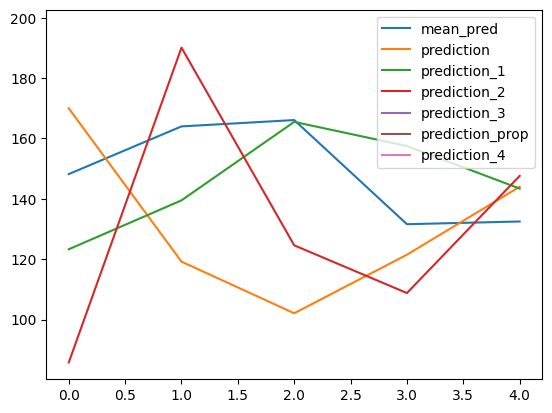

In [65]:
df.plot()
plt.show()